# Memory models on Mixture of Markov Chains

## Data

$$
\begin{align*}
\texttt{markov chain} &\sim \mathrm{MarkovChains}(\texttt{n\_states}, \texttt{order})\\
(x_1, \ldots, x_l) &\sim \texttt{markov chain} \\
\mathcal{M} = \{x^{(1)}, \ldots, x^{(n_m)}\} &\sim \texttt{markov chain}
\end{align*}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback
from tqdm import trange, tqdm

import itertools
import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers


/Users/ruixiaowang/opt/anaconda3/envs/IML_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-06 21:26:08.967963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
n_states = 16
m = 2

state_tuples = list(itertools.product(range(n_states), repeat=m))

In [3]:
def generate_random_mc(n_states, m):
    state_tuples = list(itertools.product(range(n_states), repeat=m))

    transition_dict = dict()

    for state_tuple in state_tuples:
        next_state = np.random.randint(n_states)
        p = np.zeros(n_states)
        p[next_state] = 1

        transition_dict[state_tuple] = p

    return transition_dict

In [4]:
n_train_mcs = 10_000
n_test_mcs = 10_000
train_mcs = [generate_random_mc(n_states, m) for _ in trange(n_train_mcs)]
test_mcs = [generate_random_mc(n_states, m) for _ in trange(n_test_mcs)]

100%|██████████| 10000/10000 [00:06<00:00, 1484.70it/s]


In [5]:
def sample_markov_chain(transition_dict, prefix, num_steps):
    states_seq = prefix
    m = len(list(transition_dict.keys())[0])

    for i in range(num_steps-m):
        probabilities = transition_dict[tuple(states_seq[-m:])]
        next_state = np.random.choice(range(n_states), p=probabilities)
        states_seq.append(next_state)

    return states_seq

In [6]:
input_seq_len = 32 # length of input sequences
mem_seq_len = 5*m # length of each memory sequence
mem_size = 16 # number of memory sequences

n_train = 5_000
n_test = 2_500

def sample_mem_buffer(mem_seq_len, mem_size, transition_dict, input_seq=None, num_subseq_insertions=1):
    state_tuples = list(transition_dict.keys())
    mem_seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=mem_seq_len+1)
         for _ in range(mem_size)])

    mem_seqs_x = mem_seqs[:, :-1]
    mem_seqs_y = mem_seqs[:, 1:]

    if input_seq is not None:
        x_len = len(input_seq)
        for _ in range(num_subseq_insertions):
            start_idx = np.random.randint(0, x_len - mem_seq_len - 1)
            x_subseq = input_seq[start_idx:start_idx+mem_seq_len]
            y_subseq = input_seq[start_idx+1:start_idx+1+mem_seq_len]

            mem_seqs_x = np.concatenate([mem_seqs_x, np.expand_dims(x_subseq, axis=0)])
            mem_seqs_y = np.concatenate([mem_seqs_y, np.expand_dims(y_subseq, axis=0)])

    return mem_seqs_x, mem_seqs_y


def sample_seqs_dataset(n, input_seq_len, mem_seq_len, mem_size, markov_chains, num_subseq_insertions=1):

    # sample a Markov chain for each sample in the dataset
    transition_dicts = np.random.choice(markov_chains, n)

    # sample a sequence from each Markov chain
    seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=input_seq_len+1) for transition_dict in tqdm(transition_dicts, leave=False)])

    # create x and y sequences
    seqs_x = seqs[:, :-1]
    seqs_y = seqs[:, 1:]

    # sample memory buffers from each markov chain
    mem_seqs_x, mem_seqs_y = zip(
        *[sample_mem_buffer(mem_seq_len, mem_size, transition_dict, input_seq, num_subseq_insertions=num_subseq_insertions)
          for transition_dict, input_seq in tqdm(zip(transition_dicts, seqs), leave=False)])
    mem_seqs_x, mem_seqs_y = np.array(mem_seqs_x), np.array(mem_seqs_y)

    return seqs_x, seqs_y, mem_seqs_x, mem_seqs_y, transition_dicts


seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, sampled_train_mcs = sample_seqs_dataset(
    n_train, input_seq_len, mem_seq_len, mem_size, train_mcs, num_subseq_insertions=4)
seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, sampled_test_mcs = sample_seqs_dataset(
    n_test, input_seq_len, mem_seq_len, mem_size, test_mcs, num_subseq_insertions=4)


In [7]:
print(f'seqs_x_train.shape: {seqs_x_train.shape}; seqs_y_train.shape: {seqs_y_train.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_train.shape: {mem_seqs_x_train.shape}; mem_seqs_y.shape: {mem_seqs_y_train.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

print(f'seqs_x_test.shape: {seqs_x_test.shape}; seqs_y_test.shape: {seqs_y_test.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_test.shape: {mem_seqs_x_test.shape}; mem_seqs_y_test.shape: {mem_seqs_y_test.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

seqs_x_train.shape: (5000, 32); seqs_y_train.shape: (5000, 32)
mem_seqs_x_train.shape: (5000, 20, 10); mem_seqs_y.shape: (5000, 20, 10)
seqs_x_test.shape: (2500, 32); seqs_y_test.shape: (2500, 32)
mem_seqs_x_test.shape: (2500, 20, 10); mem_seqs_y_test.shape: (2500, 20, 10)


In [8]:
fit_kwargs = dict(epochs=30)

from tqdm.keras import TqdmCallback
from tqdm import tqdm
def create_callbacks():
    return [TqdmCallback(tqdm_class=tqdm)]


# Hierarchical Attention Model

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)

2023-11-06 21:32:32.352858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
from transformer_modules import AddPositionalEmbedding, create_positional_encoding, MemoryAddPositionalEmbedding
from transformer_modules import GlobalSelfAttention, CausalSelfAttention
from hierarchical_attention import MultiHeadHierarchicalAttention


class HierarchicalAttnMemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, symmetric_attention=False, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        # self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')
        self.self_attention_layer = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.self_attention_layer
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim, symmetric_kernel=True, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        # return self.self_attention_layer(seq, seq, use_causal_mask=True)
        return self.self_attention_layer(seq)

    def memory_self_attention(self, mem_seqs):
        # lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=True)
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [41]:
vocab_size = n_states
embedding_dim = 64

hierattn_model = HierarchicalAttnMemoryModel(
    vocab_size, embedding_dim=embedding_dim, symmetric_attention=True,
    key_dim=embedding_dim//3, n_heads=3, name='memory_model')

hierattn_model(next(iter(train_ds))[0]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
hierattn_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
hierattn_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1024      
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_5 (Ca  multiple                 16509     
 usalSelfAttention)                                              
                                                                 
 mem_attn (MultiHeadHierarch  multiple                 16320     
 icalAttention)                                       

100%|██████████| 10/10 [02:18<00:00, 13.81s/epoch, loss=0.271, accuracy=0.927, val_loss=0.282, val_accuracy=0.924]


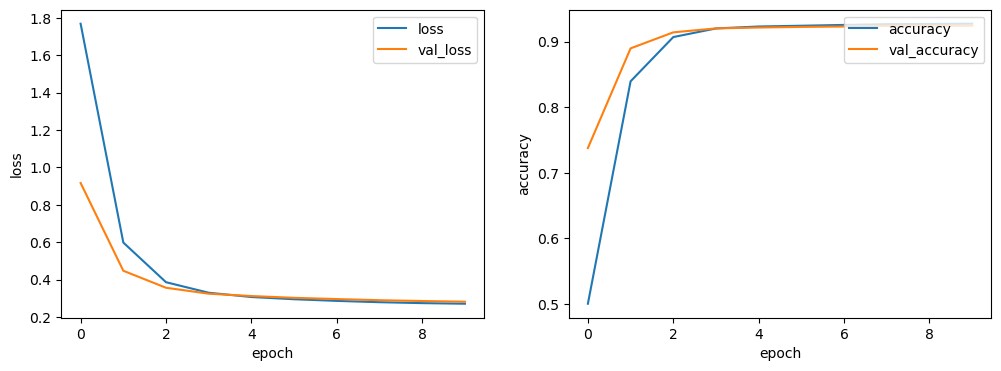

In [42]:
history = hierattn_model.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=10)
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

In [13]:
hierattn_model.evaluate(test_ds)

40/40 [==============================] - 9s 229ms/step - loss: 0.2893 - accuracy: 0.9230


[0.289341539144516, 0.9230499863624573]

40/40 [==============================] - 9s 190ms/step


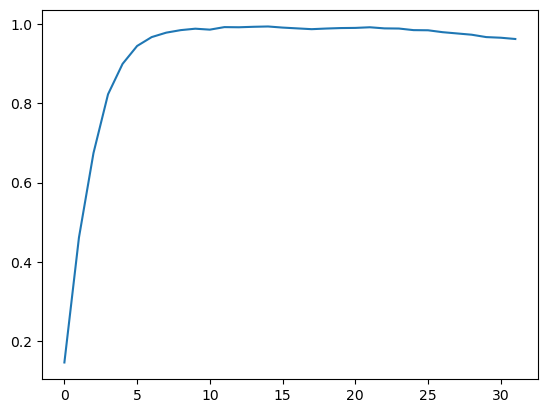

In [14]:
# plot accuracy as a function of position in sequence
preds = hierattn_model.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

In [13]:
# utilities for analyzing attention patterns in hierarchical attention model
import matplotlib.pyplot as plt
from matplotlib import gridspec


def plot_per_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig = plt.figure(figsize=(num_mem_seqs*2,3))
    gs = gridspec.GridSpec(1, num_mem_seqs+1, width_ratios=[0.5]*num_mem_seqs+[0.1])
    axs = [fig.add_subplot(gs[i]) for i in range(num_mem_seqs)]
    cax = fig.add_subplot(gs[-1])
    im = None
    for t, ax in enumerate(axs):
        im = ax.imshow(attn_[t], cmap='gray', vmin=0, vmax=1)
        ax.set_xticks(range(len(mem_seqs_x[t])))
        ax.set_yticks(range(len(train_seqs_x)))
        ax.set_xticklabels(mem_seqs_x[t]);
        ax.set_yticklabels(train_seqs_x);
    fig.colorbar(im, cax=cax)
    axs[0].set_ylabel('input sequence')
    fig.supxlabel('memory sequences', y=0.)
    fig.suptitle('attention within each memory sequence')
    return fig

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x, **figkwargs):

    fig, ax = plt.subplots(figsize=(len(train_seqs_x), len(mem_seqs_x)))
    cmap = 'gray' if attn_.shape[-1] == 1 else None
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax);
    return fig


def plot_attention_hierarchical(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

    fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])
    attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

sample_input:  [[ 3  2 12  9  3  7 12 12 15  1  8  4 10 10  3  5 15 10  9  0 11 15 13  2
  12  9  3  7 12 12 15  1]]
prediction: [ 5 12  9  3  7 12 12 15  1  8  4 10 10  3  5 15 10  9  0 11 15 13  2 12
  9  3  7 12 12 15  1  8]
y: [ 2 12  9  3  7 12 12 15  1  8  4 10 10  3  5 15 10  9  0 11 15 13  2 12
  9  3  7 12 12 15  1  8]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


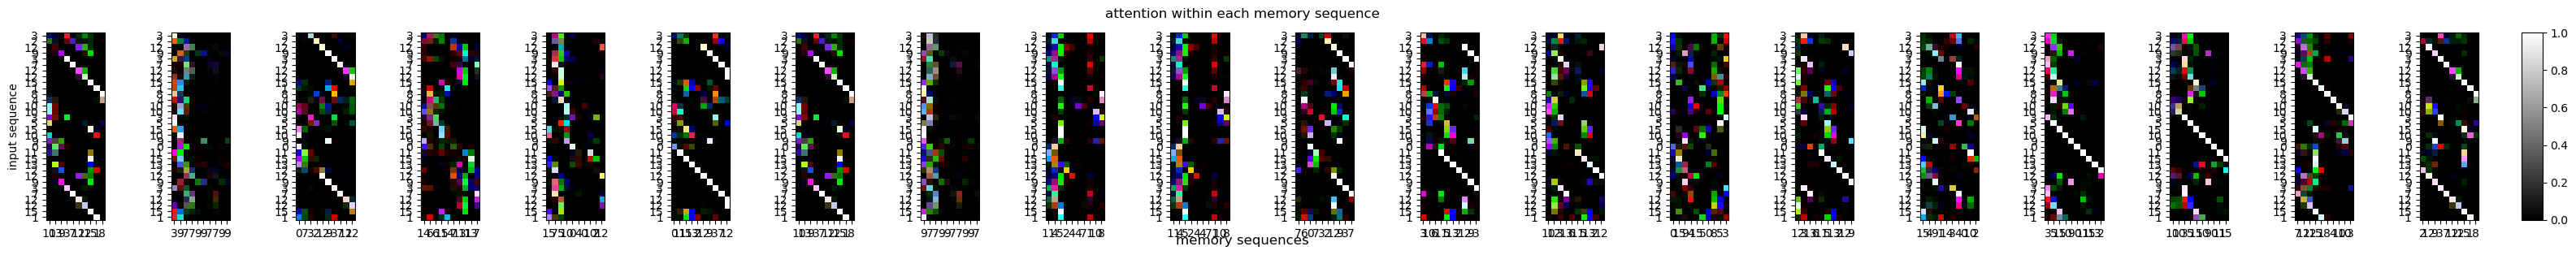

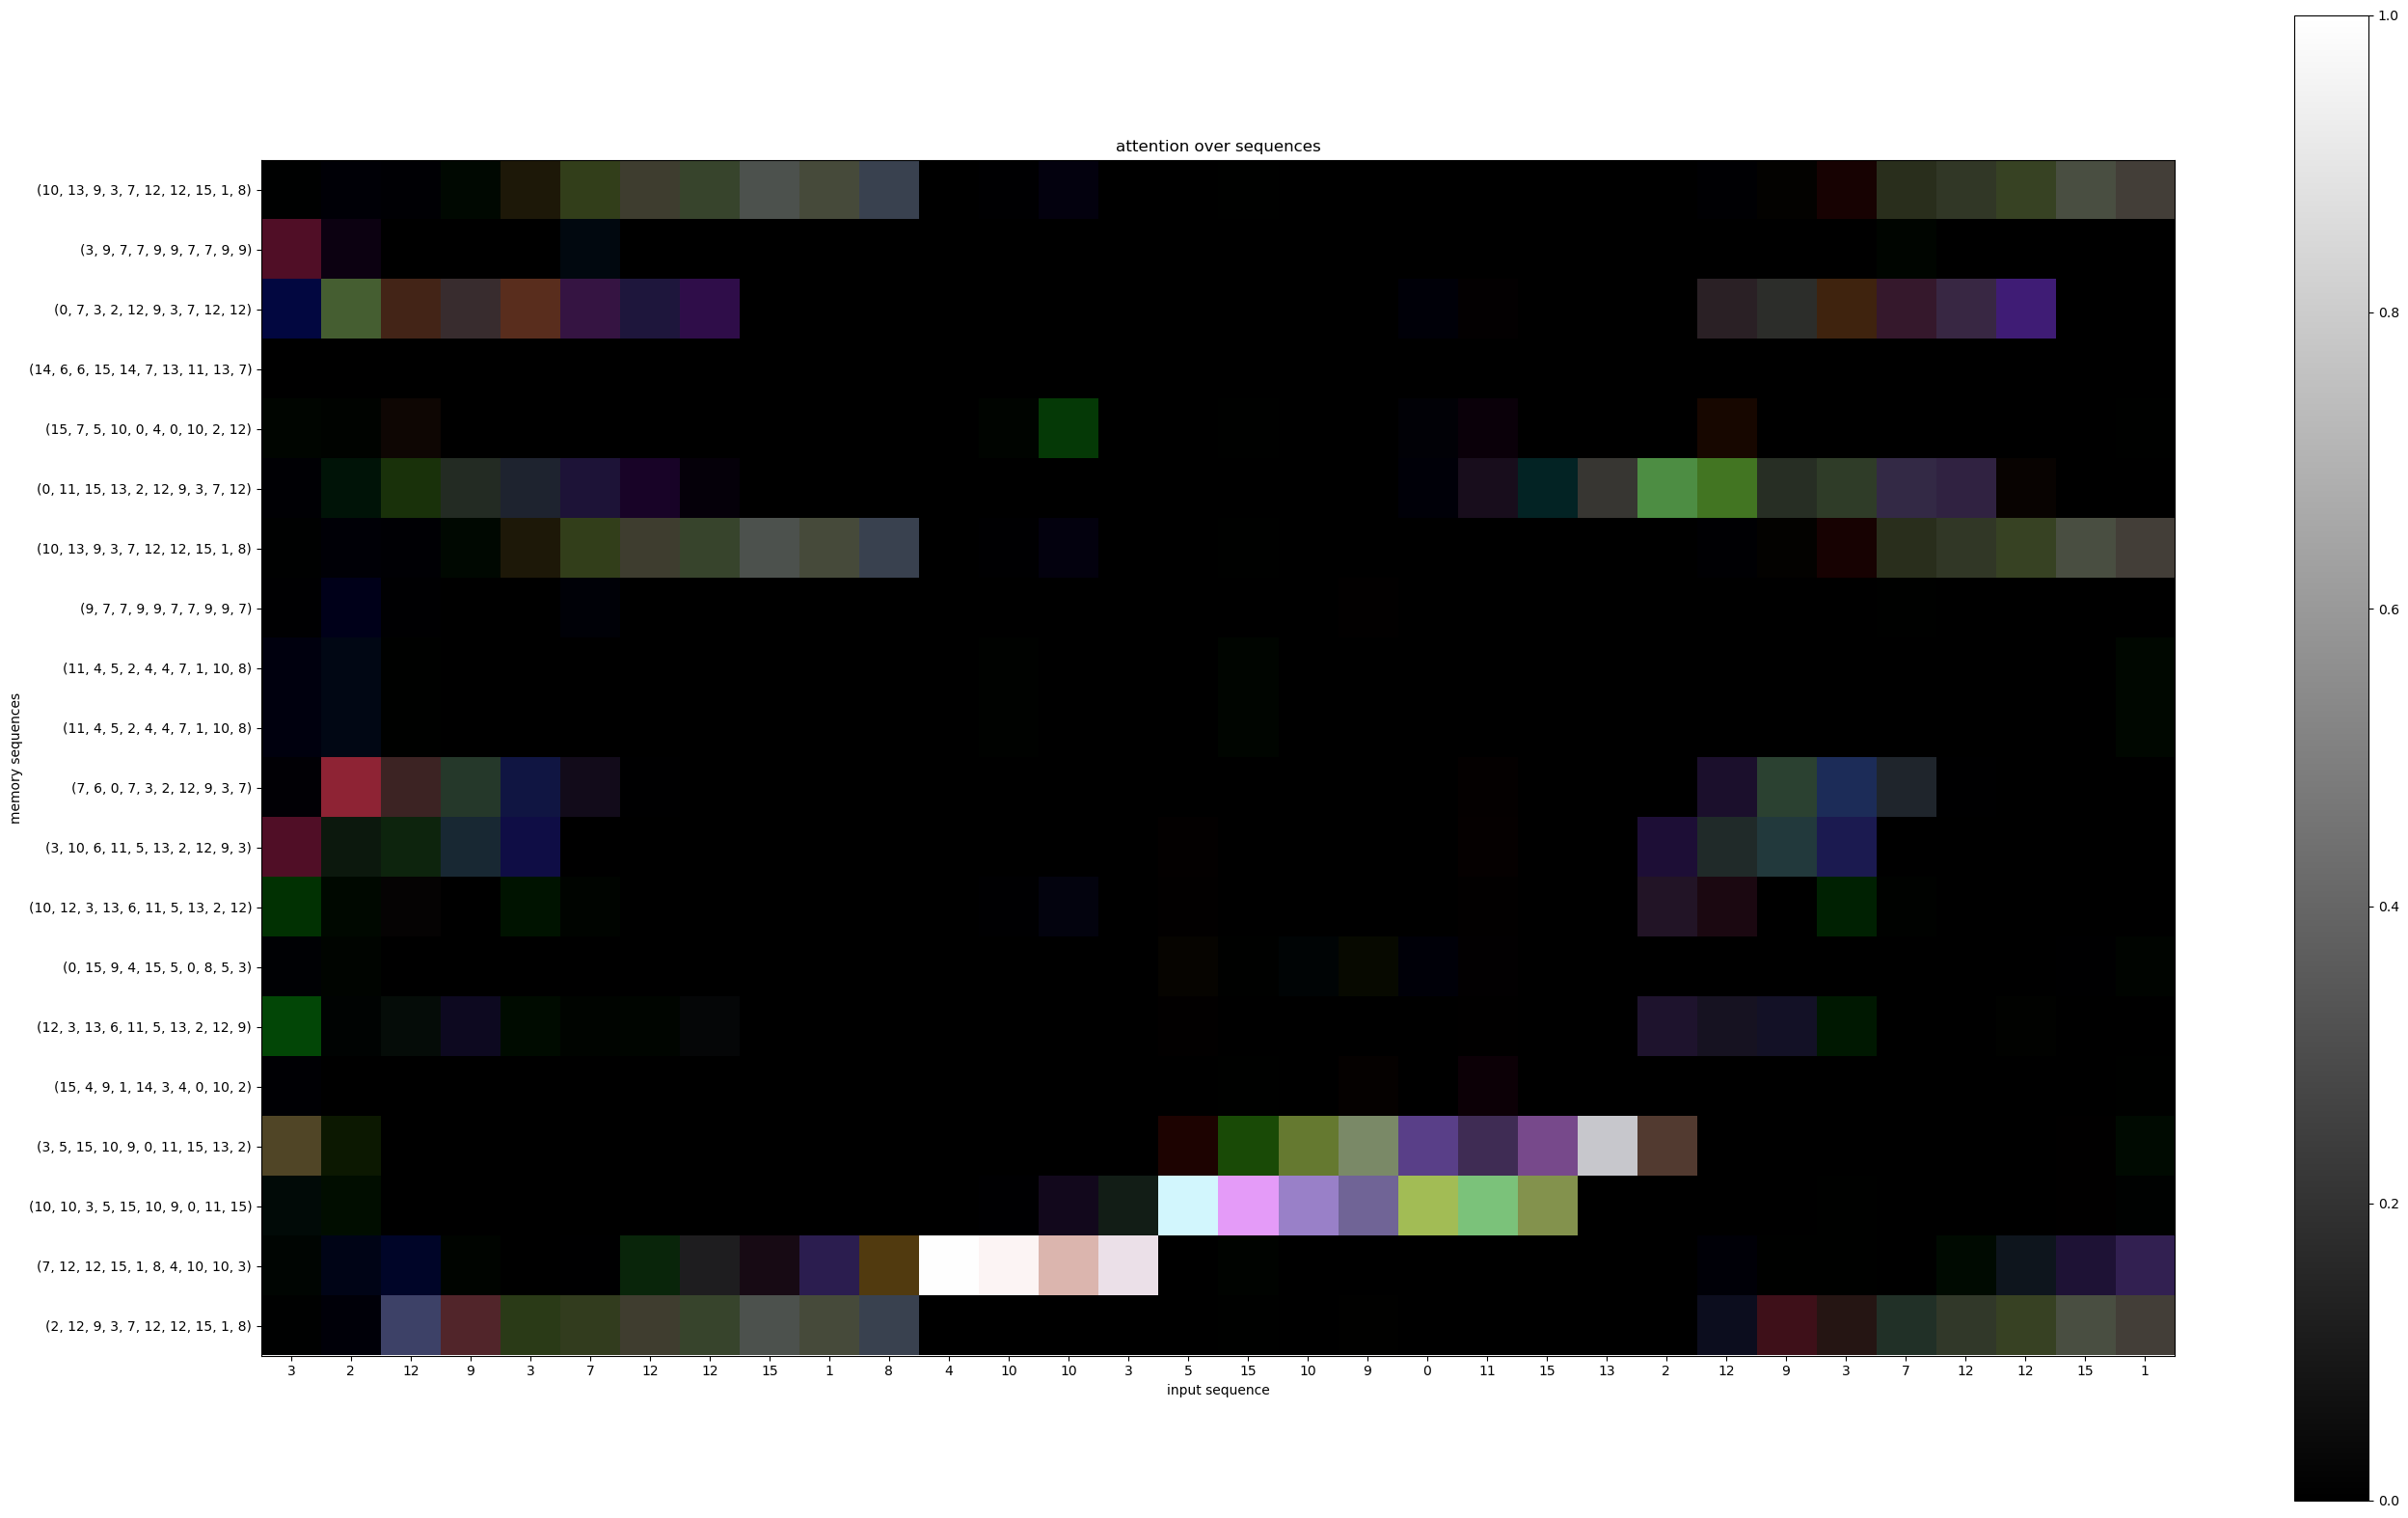

In [14]:
idx = np.random.choice(len(seqs_x_test))

plot_attention_hierarchical(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, hierattn_model)

100%|██████████| 6/6 [00:23<00:00,  3.92s/it]


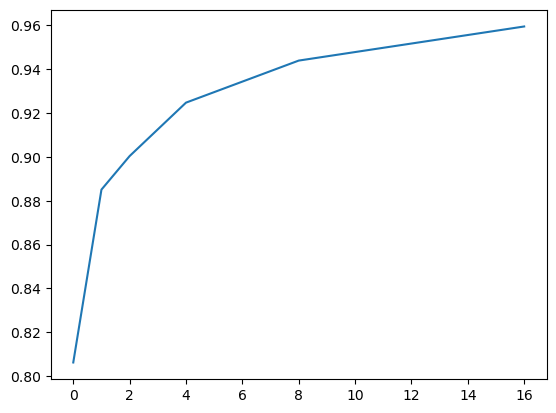

In [28]:
accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    seqs_x_test_, seqs_y_test_, mem_seqs_x_test_, mem_seqs_y_test_, sampled_test_mcs_ = sample_seqs_dataset(
        500, input_seq_len, mem_seq_len, mem_size, train_mcs, num_subseq_insertions=num_subseqs)

    test_ds_ = tf.data.Dataset.from_tensor_slices(((seqs_x_test_, mem_seqs_x_test_, mem_seqs_y_test_), seqs_y_test_)).batch(64)
    _, acc = hierattn_model.evaluate(test_ds_, verbose=0)
    accs.append(acc)

plt.plot(nums_subseqs, accs)

In [18]:
from kernel_memory_transformer import KernelMemoryTransformer

train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)

# Kernel Model with discounting factor on the past

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from custom_attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, symmetric_attention=False, crossAttn_value_shifted=False, gamma=0,**kwargs):
        super().__init__(**kwargs)

        self.gamma = gamma
        self.symmetric_attention = symmetric_attention
        self.crossAttn_value_shifted = crossAttn_value_shifted
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')
        
        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.input_self_attention
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # create cross attention layer                             
        self.cross_attention_layer = CrossAttention(num_heads=n_heads, key_dim=key_dim, value_dim = key_dim, symmetric_attention=symmetric_attention, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''
       
        def get_memory_cross_probs(Et, Et_y):
            cross_attention_output = self.cross_attention_layer(
                x=embedded_input_seqs,
                context=Et,
                y=Et_y)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)

        # compute cross-attention for each memory
        embedded_mem_x_seqs = tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3])
        if self.crossAttn_value_shifted:
            embedded_mem_y_seqs = tf.transpose(embedded_mem_y_seqs, perm=[1, 0, 2, 3]) 
        else:
             embedded_mem_y_seqs =  embedded_mem_x_seqs
             
        cross_probs = tf.map_fn(lambda xy: get_memory_cross_probs(xy[0], xy[1]), 
                            (embedded_mem_x_seqs, embedded_mem_y_seqs),
                            dtype=tf.float32)
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components corresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed


    def compute_mem_attention_scores(self, cross_probs_observed, input_seq_length):
        log_cross_probs_observed = tf.math.log(cross_probs_observed)

        # Initialize the first element of w_it with zeros
        # The first element is zeros, and the rest is calculated by tf.scan
        def scan_func(prev_w, curr_log_prob):
            next_w = self.gamma * prev_w + curr_log_prob
            return next_w

        #print("log_cross_probs_observed", log_cross_probs_observed)
        w_it = tf.scan(scan_func, tf.transpose(log_cross_probs_observed, perm=[2,1,0]))
        w_it = tf.transpose(w_it, perm=[2,1,0])
        #print("w_it", w_it)
        
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it  
    
    def call(self, inputs):
        
        # handle crossAttn value
        embedded_mem_y_seqs = None
        if self.crossAttn_value_shifted:
            seq_input, memory_input, memory_output = inputs
            embedded_mem_y_seqs = self.embedder(memory_output)
            embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
        else:
            seq_input, memory_input = inputs
        

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)
    
        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs_mem_on = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs_mem_on, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        input_seq_len = seq_input.shape[-1]
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed, input_seq_len)
        self.alpha_it = alpha_it

        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs_mem_on), axis=1)

        return output


In [28]:
vocab_size = n_states
embedding_dim = 64
kernel_model_cross_y = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size,], symmetric_attention = True, crossAttn_value_shifted = True, gamma=0.7, name='kernel_model_cross_y')


kernel_model_cross_y([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_cross_y.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_cross_y.summary()

Model: "kernel_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1024      
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_3 (Ca  multiple                 12608     
 usalSelfAttention)                                              
                                                                 
 cross_attention_2 (CrossAtt  multiple                 8448      
 ention)                                      

  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/30 [00:34<?, ?epoch/s]










100%|██████████| 30/30 [06:27<00:00, 12.92s/epoch, loss=0.392, accuracy=0.9, val_loss=0.443, val_accuracy=0.887]  


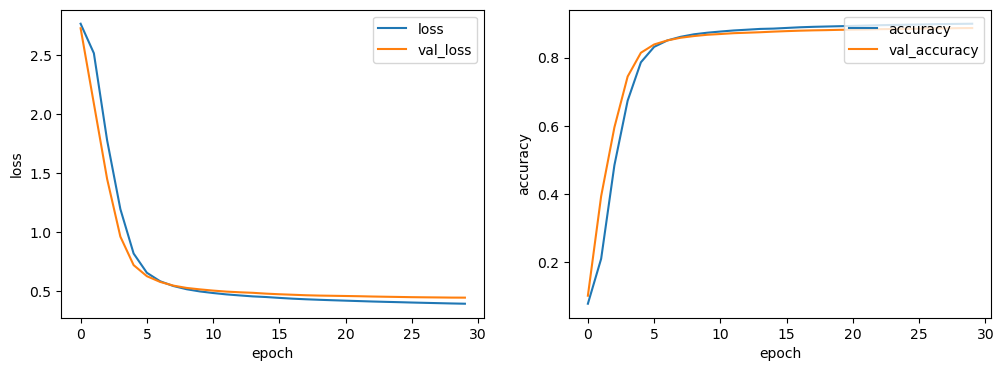

In [29]:
history3 = kernel_model_cross_y.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history3, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

40/40 [==============================] - 3s 39ms/step


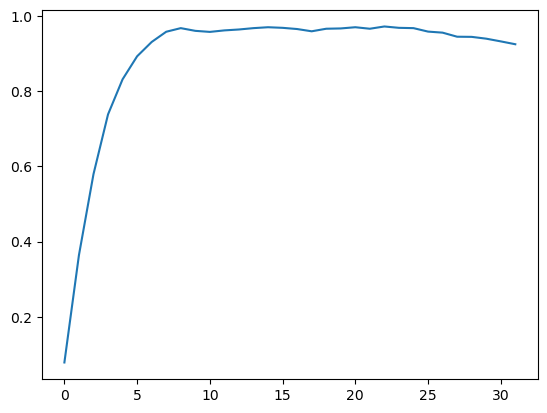

In [30]:
# plot accuracy as a function of position in sequence
preds = kernel_model_cross_y.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

In [33]:
def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x, title):
    num_mem_seqs = attn_.shape[0]
    fig, ax = plt.subplots(figsize=(num_mem_seqs*4,12))
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title(title)

    fig.colorbar(im, ax=ax)
    
    
def plot_attention(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    cross_probs_observed = memory_model.cross_probs_observed[0]
    attn_ = memory_model.alpha_it[0]
    plot_seq_attention(cross_probs_observed, sample_mem_seq_x[0], sample_input[0], "probability of predicting the next observed token given previous input and memory x^(t)")
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0], "alpha_it attention")
    
def plot_cross_prob_observed_and_attn_crossAttn_y(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    #cross_probs_observed = memory_model.cross_probs_observed[0]
    attn_ = memory_model.alpha_it[0]
    #plot_seq_attention(cross_probs_observed, sample_mem_seq_x[0], sample_input[0], "probability of predicting the next observed token given previous input and memory x^(t)")
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0], "alpha_it attention")
    

kernel_model_cross_y
sample_input:  [[14  7  3  5  7  4  3 10  7  7  3  5  7  4  3 10  7  7  3  5  7  4  3 10
   7  7  3  5  7  4  3 10]]
prediction: [ 3  3  5  7  3  3 10  7  7  3  5  7  4  3 10  7  7  3  5  7  4  3 10  7
  7  3  5  7  4  3 10  7]
y: [ 7  3  5  7  4  3 10  7  7  3  5  7  4  3 10  7  7  3  5  7  4  3 10  7
  7  3  5  7  4  3 10  7]
[False  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


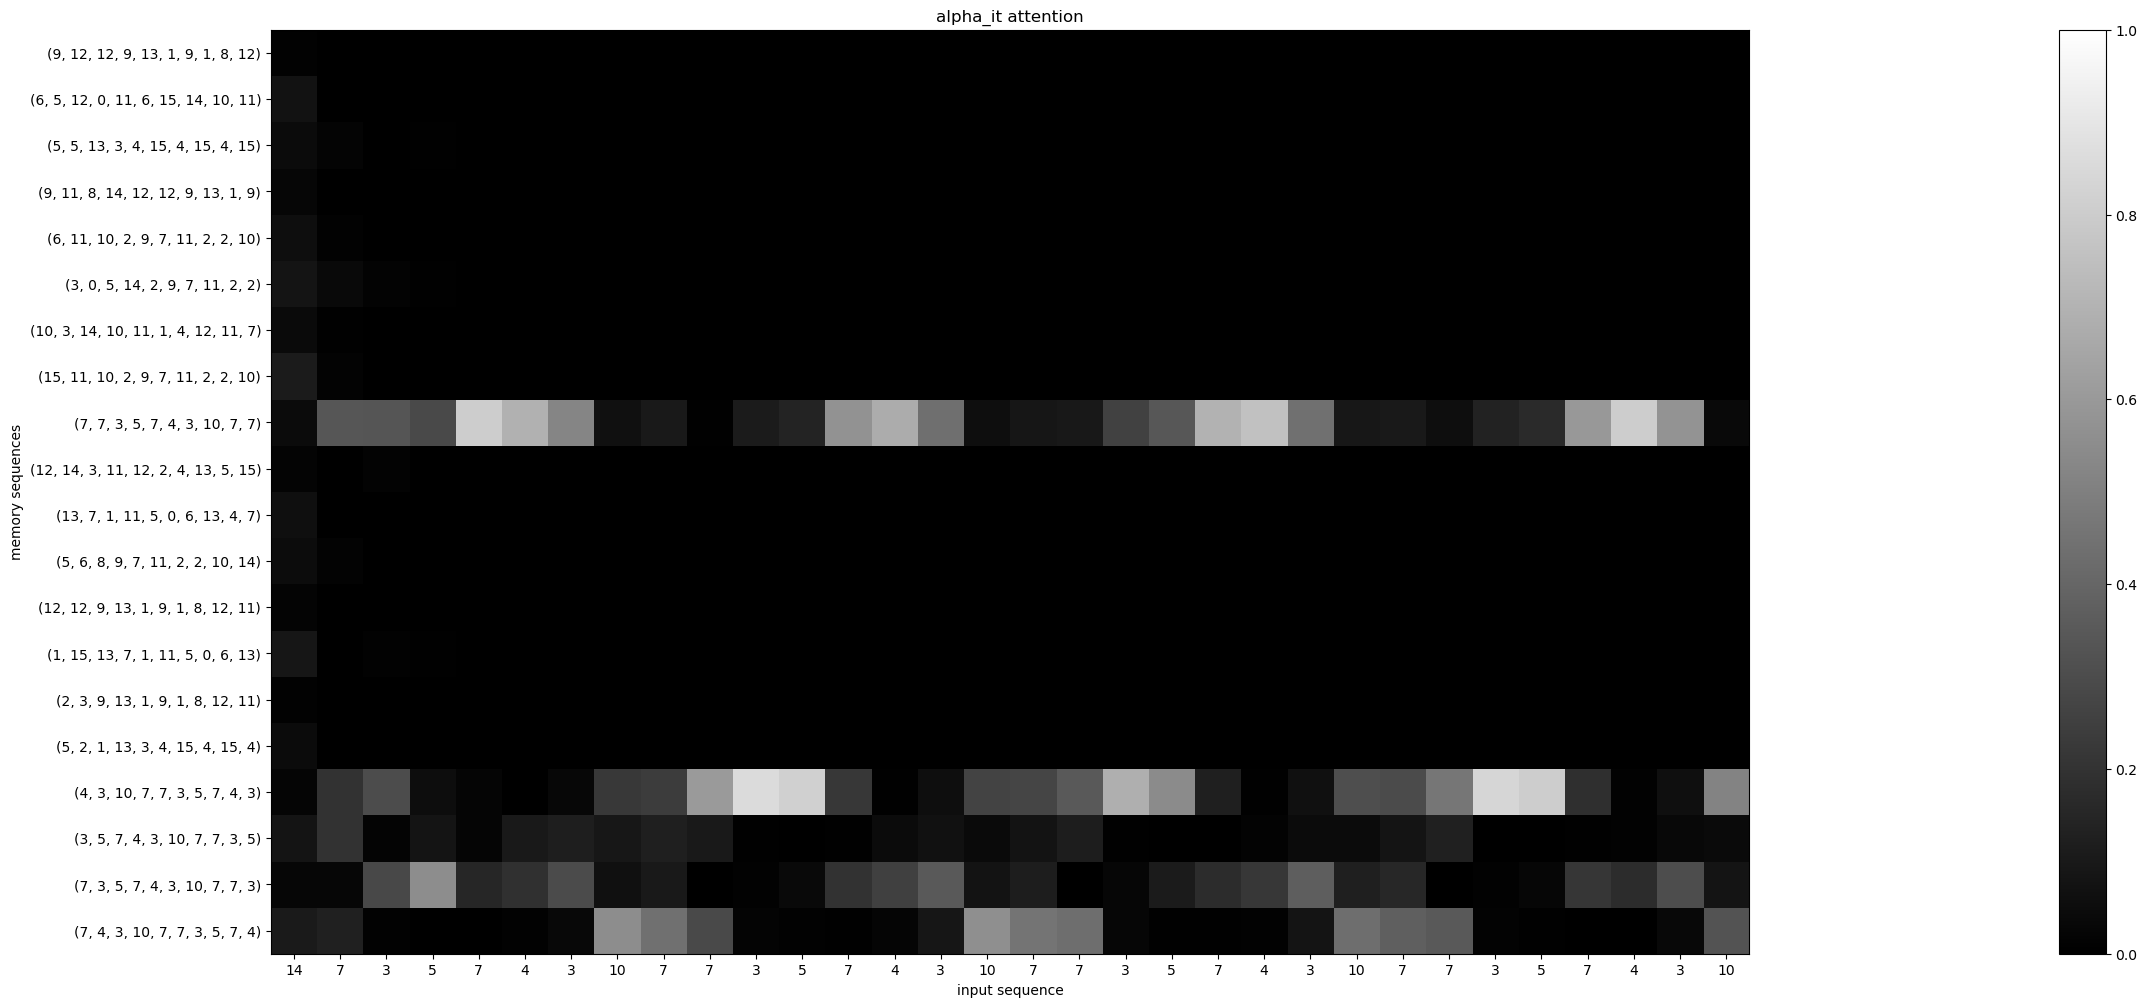

In [34]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y')

plot_cross_prob_observed_and_attn_crossAttn_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y)

kernel_model_cross_y
sample_input:  [[ 0  9  3  5  4  3 15  6  5  4  3 15  6  5  4  3 15  6  5  4  3 15  6  5
   4  3 15  6  5  4  3 15]]
prediction: [13  5  5  4  3 15  6  5  4  3 15  6  5  4  3 15  6  5  4  3 15  6  5  4
  3 15  6  5  4  3 15  6]
y: [ 9  3  5  4  3 15  6  5  4  3 15  6  5  4  3 15  6  5  4  3 15  6  5  4
  3 15  6  5  4  3 15  6]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


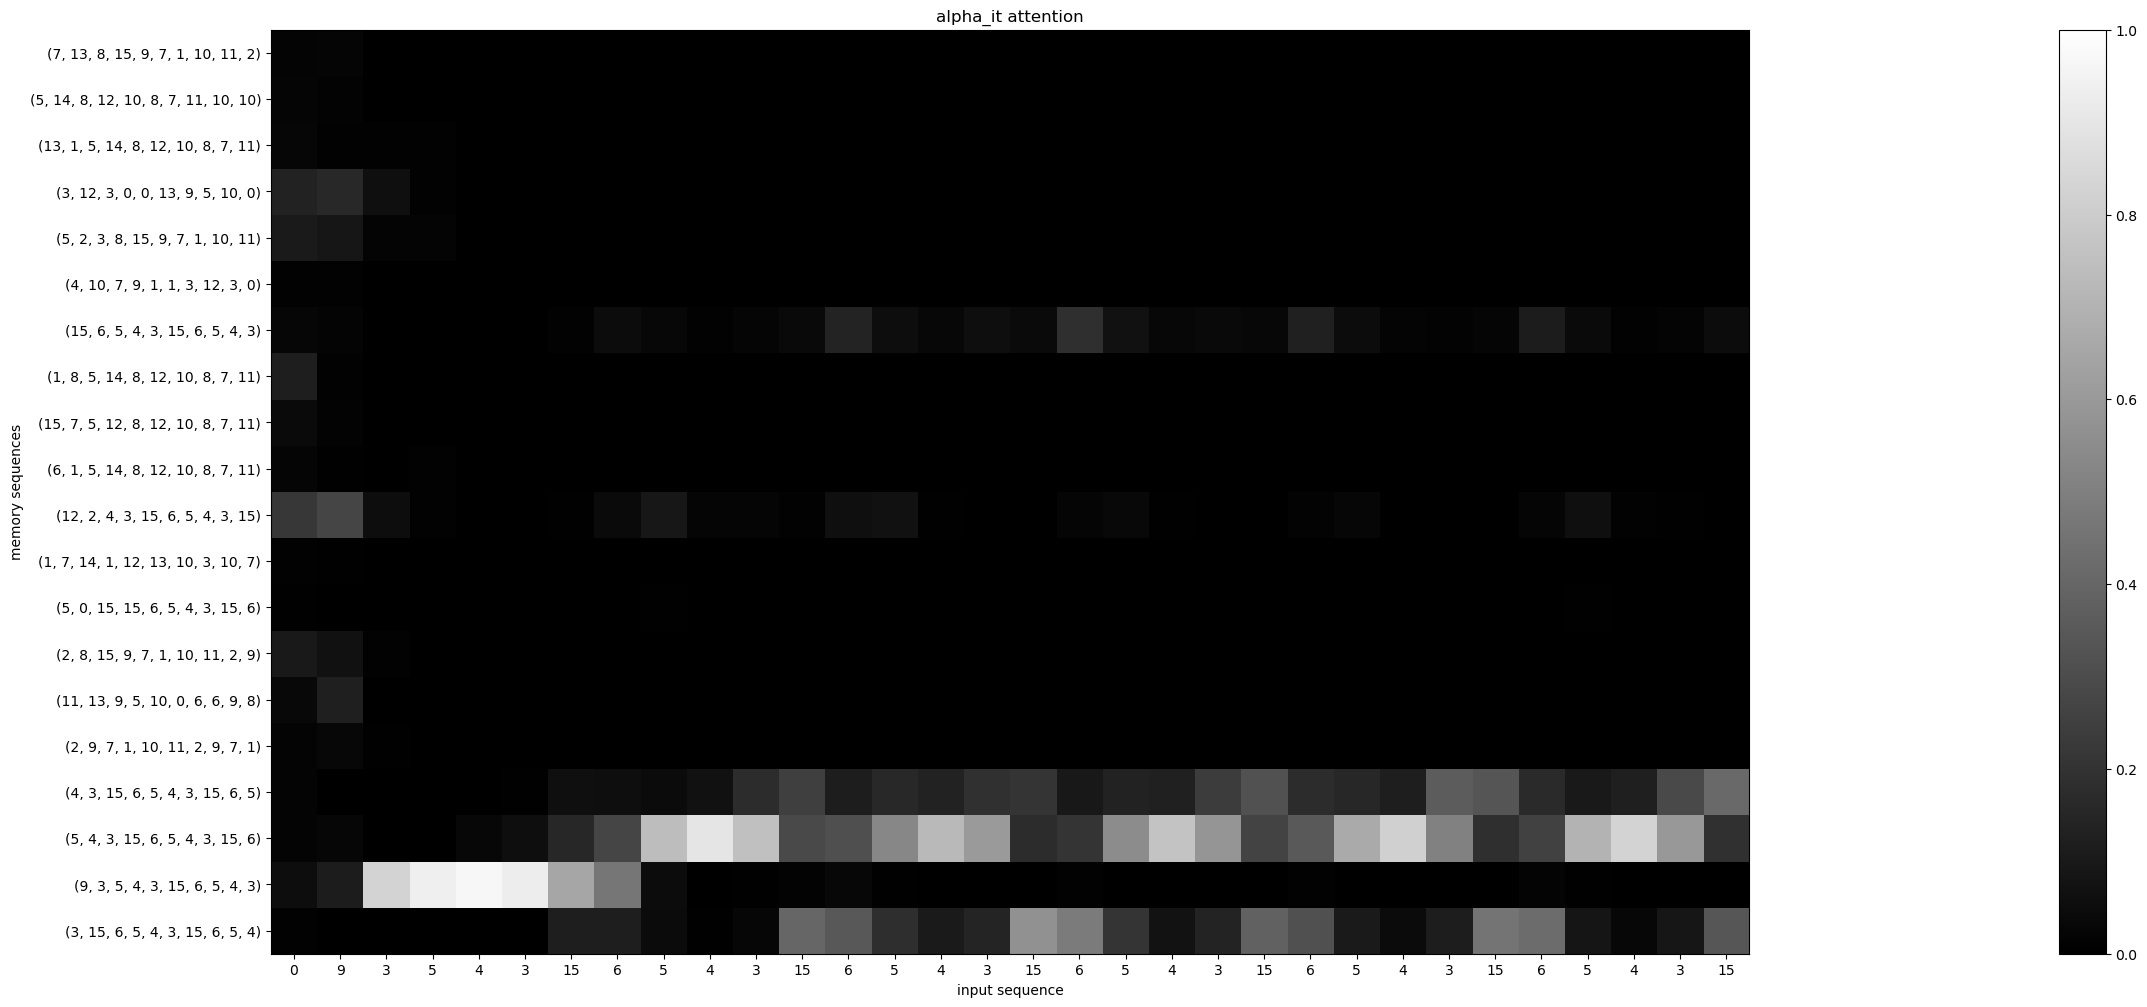

In [35]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y')

plot_cross_prob_observed_and_attn_crossAttn_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


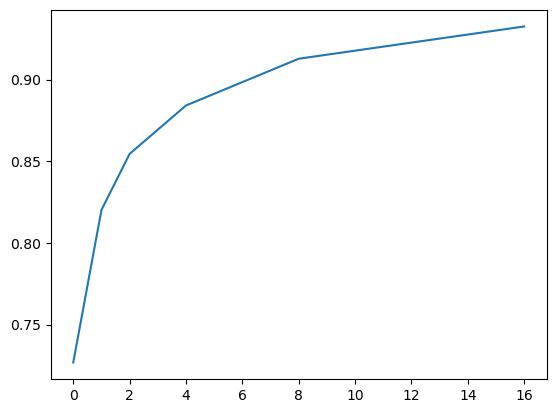

In [32]:

accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    seqs_x_test_, seqs_y_test_, mem_seqs_x_test_, mem_seqs_y_test_, sampled_test_mcs_ = sample_seqs_dataset(
        500, input_seq_len, mem_seq_len, mem_size, test_mcs, num_subseq_insertions=num_subseqs)

    test_ds_ = tf.data.Dataset.from_tensor_slices(((seqs_x_test_, mem_seqs_x_test_, mem_seqs_y_test_), seqs_y_test_)).batch(64)
    _, acc = kernel_model_cross_y.evaluate(test_ds_, verbose=0)
    accs.append(acc)

plt.plot(nums_subseqs, accs)

In [53]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from custom_attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, symmetric_attention=False, crossAttn_value_shifted=False, gamma=0,**kwargs):
        super().__init__(**kwargs)

        self.gamma = gamma
        self.symmetric_attention = symmetric_attention
        self.crossAttn_value_shifted = crossAttn_value_shifted
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')
        
        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.input_self_attention
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # create cross attention layer                             
        self.cross_attention_layer = CrossAttention(num_heads=n_heads, key_dim=key_dim, value_dim = key_dim, symmetric_attention=symmetric_attention, name='cross_attn')

        self.feedforward = layers.Dense(embedding_dim, activation='relu')
        self.layerNorm = layers.LayerNormalization(axis=-1)
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''
       
        def get_memory_cross_probs(Et, Et_y):
            cross_attention_output = self.cross_attention_layer(
                x=embedded_input_seqs,
                context=Et,
                y=Et_y)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)

        # compute cross-attention for each memory
        embedded_mem_x_seqs = tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3])
        if self.crossAttn_value_shifted:
            embedded_mem_y_seqs = tf.transpose(embedded_mem_y_seqs, perm=[1, 0, 2, 3]) 
        else:
             embedded_mem_y_seqs =  embedded_mem_x_seqs
             
        cross_probs = tf.map_fn(lambda xy: get_memory_cross_probs(xy[0], xy[1]), 
                            (embedded_mem_x_seqs, embedded_mem_y_seqs),
                            dtype=tf.float32)
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via LayerNorm and feedforward network
        layerNorm = self.layerNorm(cross_probs)
        cross_probs = self.feedforward(cross_probs) + layerNorm
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components corresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed


    def compute_mem_attention_scores(self, cross_probs_observed, input_seq_length):
        log_cross_probs_observed = tf.math.log(cross_probs_observed)

        # Initialize the first element of w_it with zeros
        # The first element is zeros, and the rest is calculated by tf.scan
        def scan_func(prev_w, curr_log_prob):
            next_w = self.gamma * prev_w + curr_log_prob
            return next_w

        #print("log_cross_probs_observed", log_cross_probs_observed)
        w_it = tf.scan(scan_func, tf.transpose(log_cross_probs_observed, perm=[2,1,0]))
        w_it = tf.transpose(w_it, perm=[2,1,0])
        
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it  
    
    def call(self, inputs):
        
        # handle crossAttn value
        embedded_mem_y_seqs = None
        if self.crossAttn_value_shifted:
            seq_input, memory_input, memory_output = inputs
            embedded_mem_y_seqs = self.embedder(memory_output)
            embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
        else:
            seq_input, memory_input = inputs
        

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)
        
    
        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs_mem_on = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs_mem_on, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        input_seq_len = seq_input.shape[-1]
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed, input_seq_len)
        self.alpha_it = alpha_it

        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs_mem_on), axis=1)

        return output


In [54]:
vocab_size = n_states
embedding_dim = 64
kernel_model_cross_y = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size,], symmetric_attention = True, crossAttn_value_shifted = True, gamma=0.7, name='kernel_model_cross_y')


kernel_model_cross_y([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_cross_y.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_cross_y.summary()

Model: "kernel_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1024      
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_9 (Ca  multiple                 12608     
 usalSelfAttention)                                              
                                                                 
 cross_attention_7 (CrossAtt  multiple                 8448      
 ention)                                      

100%|██████████| 10/10 [02:28<00:00, 14.85s/epoch, loss=0.464, accuracy=0.882, val_loss=0.476, val_accuracy=0.879]


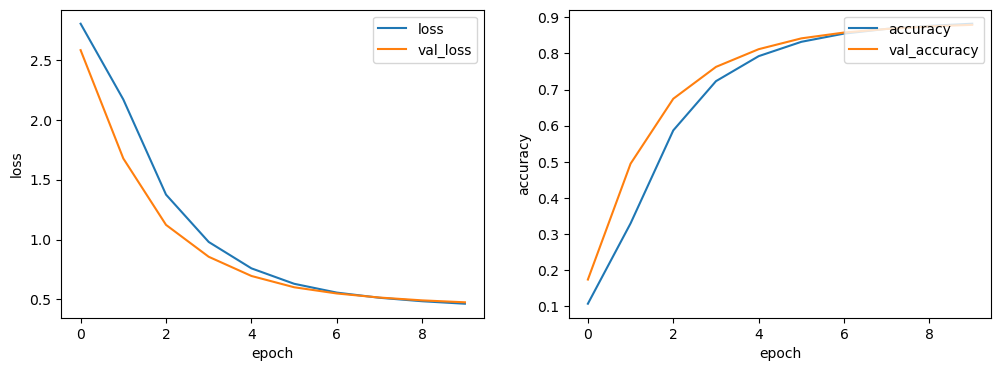

In [55]:
fit_kwargs = dict(epochs=10)
history4 = kernel_model_cross_y.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history4, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

40/40 [==============================] - 3s 47ms/step


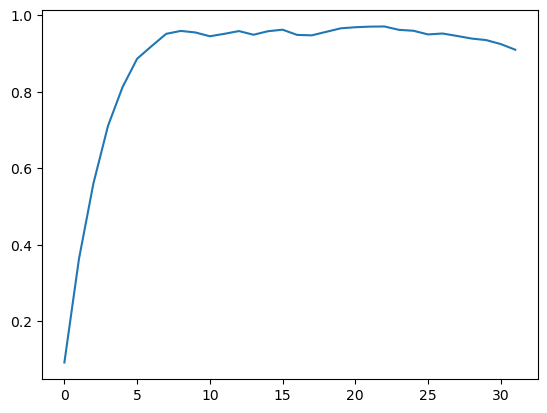

In [56]:
# plot accuracy as a function of position in sequence
preds = kernel_model_cross_y.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

kernel_model_cross_y
sample_input:  [[15 12  5  6 15 11  9  9 12  8  3 13  5  6 15 11  9  9 12  8  3 13  5  6
  15 11  9  9 12  8  3 13]]
prediction: [11 11  6 15 11  9  9 12  8  3 13  5  6 15 11  9  9 12  8  3 13  5  6 15
 11  9  9 12  8  3 13  5]
y: [12  5  6 15 11  9  9 12  8  3 13  5  6 15 11  9  9 12  8  3 13  5  6 15
 11  9  9 12  8  3 13  5]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


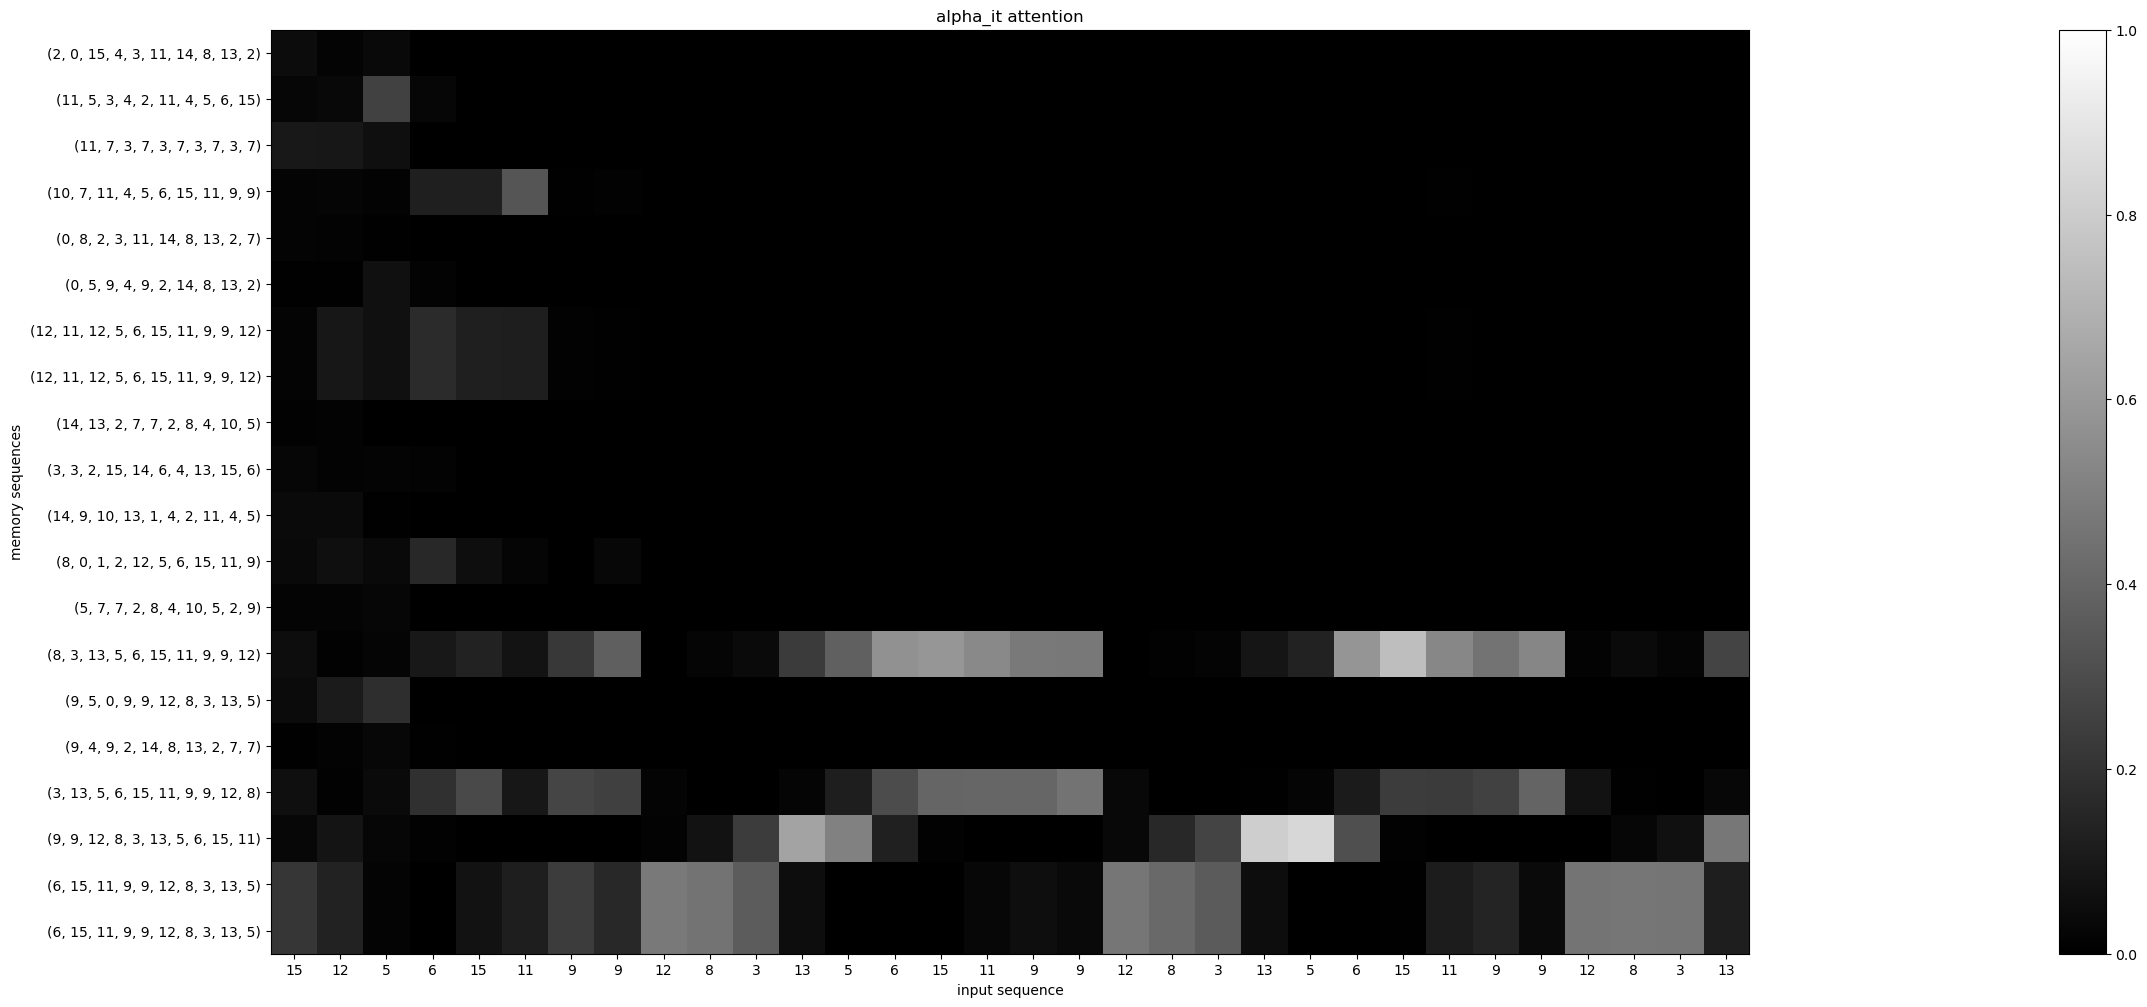

In [57]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y')

plot_cross_prob_observed_and_attn_crossAttn_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y)

kernel_model_cross_y
sample_input:  [[14  1  9  7  2  5  0  3 10  9  5  9  3  2  4  2 15  3 10  9  5  9  3  2
   4  2 15  3 10  9  5  9]]
prediction: [ 1  9  7  2  5  0  3 10  9  5  0  3  2  4  2 15  3 10  9  5  9  3  2  4
  2 15  3 10  9  5  9  3]
y: [ 1  9  7  2  5  0  3 10  9  5  9  3  2  4  2 15  3 10  9  5  9  3  2  4
  2 15  3 10  9  5  9  3]
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


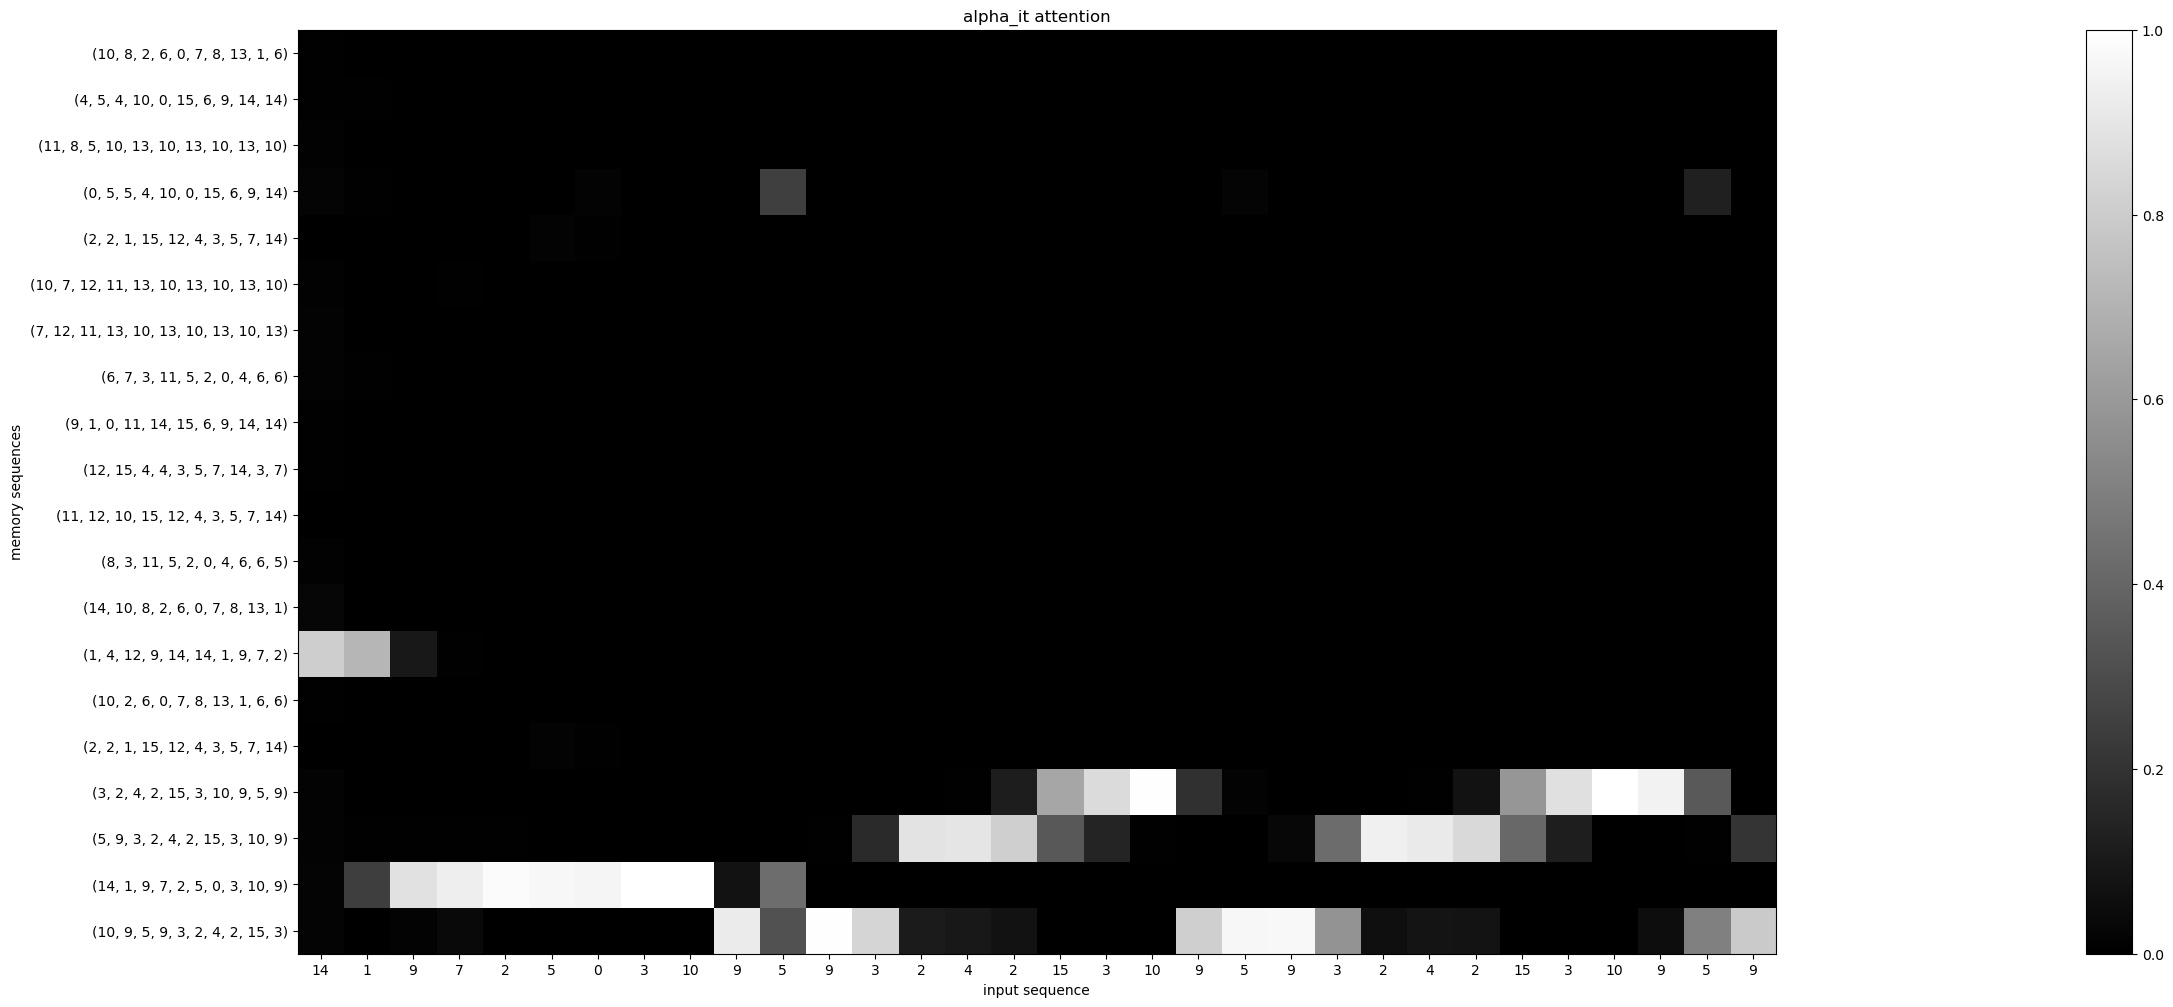

In [44]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y')

plot_cross_prob_observed_and_attn_crossAttn_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


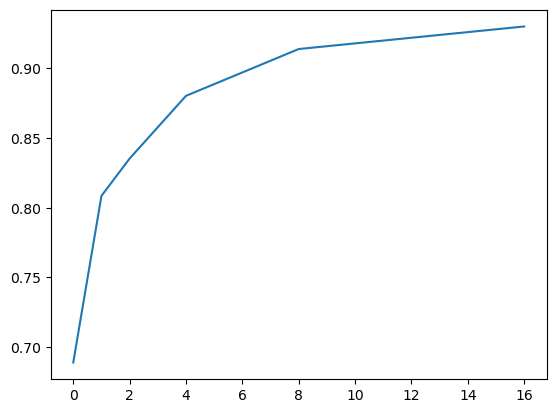

In [58]:
accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    seqs_x_test_, seqs_y_test_, mem_seqs_x_test_, mem_seqs_y_test_, sampled_test_mcs_ = sample_seqs_dataset(
        500, input_seq_len, mem_seq_len, mem_size, test_mcs, num_subseq_insertions=num_subseqs)

    test_ds_ = tf.data.Dataset.from_tensor_slices(((seqs_x_test_, mem_seqs_x_test_, mem_seqs_y_test_), seqs_y_test_)).batch(64)
    _, acc = kernel_model_cross_y.evaluate(test_ds_, verbose=0)
    accs.append(acc)

plt.plot(nums_subseqs, accs)